In [ ]:
# unintended bias analysis

# 1) ROC-AUC
# 2) FPED, and FNED
# 3) Sub AUC, BPSN, and BNSP
# 4) Weighted bias score
# 5) Pos AEG, Neg AEGb

In [99]:
# imports from other files
from danlp.models.embeddings  import load_wv_with_gensim
from gensim.models import KeyedVectors
from IPython.display import Image
import json
from keras import layers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, plot_model
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
from scipy.stats import mannwhitneyu
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import tensorflow as tf # tf backend
from tqdm import tqdm
from typing import Dict, List
import utils

In [2]:
# specific imports
from sklearn.metrics import roc_auc_score, roc_curve

### Load data and models

In [3]:
# load preprocessed and oversampled data splits

if "dataset_splits.pkl" not in os.listdir('data'):
    raise Exception("Dataset splits not found. Please run main file to generate them.")

with open("data/dataset_splits.pkl", "rb") as f:
    data = pickle.load(f)
    
X_train = data["X training preprocessed and oversampled"]
y_train = data["y training preprocessed and oversampled"]
X_test = data["X test preprocessed"]
y_test = data["y test"]

print("Shapes:")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Shapes:
(3424,) (3424,)
(658,) (658,)


In [4]:
# load test set
with open("data/X_test_cnn.pkl", "rb") as f:
    X_test_padded = pickle.load(f)

In [5]:
# open cnn results (incl. proba and pred)
with open("models/cnn_results.pkl", "rb") as f:
    cnn_results = pickle.load(f)

#### Load and predict synthetic data

In [6]:
# load synthetic data
synth_data = pd.read_excel("g:/My Drive/ITC, 5th semester (Thesis)/Code/Github_code/create_synthetic_dataset/synthetic_data.xlsx")

# all data
X_synth = synth_data['text']
y_synth = synth_data['toxic']

print(len(X_synth), "sentences")
synth_data.head()

# load preprocessed, tokenized and padded version of X_synth
with open("data/X_synthetic_data_prepared.pkl", "rb") as f:
    X_synth_padded = pickle.load(f)

12780 sentences


In [7]:
# predict synthetic dataset using models
# store predictions in the dataframe

for i in range(1,11): # for each version of the model
    model_path = "models/initializations/cnn"+str(i)+".keras"
    model = tf.keras.models.load_model(model_path) # load model
    print(model_path)
    
    # predict synthetic dataset
    synth_data["proba"+str(i)] = model.predict(X_synth_padded)
    synth_data["pred"+str(i)] = synth_data["proba"+str(i)] > 0.5
    synth_data["pred"+str(i)] = synth_data["pred"+str(i)].astype(int)

models/initializations/cnn1.keras
400/400 [==============================] - 3s 6ms/step
models/initializations/cnn2.keras
400/400 [==============================] - 3s 6ms/step
models/initializations/cnn3.keras
400/400 [==============================] - 2s 6ms/step
models/initializations/cnn4.keras
400/400 [==============================] - 2s 6ms/step
models/initializations/cnn5.keras
400/400 [==============================] - 2s 5ms/step
models/initializations/cnn6.keras
400/400 [==============================] - 2s 5ms/step
models/initializations/cnn7.keras
400/400 [==============================] - 3s 6ms/step
models/initializations/cnn8.keras
400/400 [==============================] - 2s 6ms/step
models/initializations/cnn9.keras
400/400 [==============================] - 2s 6ms/step
models/initializations/cnn10.keras
400/400 [==============================] - 2s 5ms/step


In [8]:
synth_data.head()

,text,group,identity_term,toxic,proba1,pred1,proba2,pred2,proba3,pred3,...,proba6,pred6,proba7,pred7,proba8,pred8,proba9,pred9,proba10,pred10
0,kvinder er klamme og generelt bare nederen,F,kvinder,1,0.860267,1,0.790226,1,0.780334,1,...,0.938523,1,0.592184,1,0.495544,0,0.972040,1,0.534409,1
1,piger er klamme og generelt bare nederen,F,piger,1,0.935613,1,0.877067,1,0.945209,1,...,0.972336,1,0.820294,1,0.785956,1,0.994204,1,0.648751,1
2,damer er klamme og generelt bare nederen,F,damer,1,0.871904,1,0.810125,1,0.841771,1,...,0.956350,1,0.719296,1,0.469115,0,0.990063,1,0.563611,1
3,koner er klamme og generelt bare nederen,F,koner,1,0.937717,1,0.819467,1,0.881572,1,...,0.949109,1,0.748725,1,0.713821,1,0.992084,1,0.567955,1
4,kvindfolk er klamme og generelt bare nederen,F,kvindfolk,1,0.953397,1,0.928839,1,0.973849,1,...,0.985285,1,0.861373,1,0.736401,1,0.997373,1,0.662934,1


### 1) ROC-AUC

In [9]:
# ROC-AUC on test set 

aucs_test = [roc_auc_score(y_test, cnn_results[model]['proba']) for model in cnn_results.keys()]
print("Avg. AUC:", round(np.mean(aucs_test), 4))

Avg. AUC: 0.7981


In [10]:
# ROC-AUC on synthetic data set 

aucs_synthetic = []
for i in range(1,11):
    proba = synth_data['proba'+str(i)]
    aucs_synthetic.append(roc_auc_score(y_synth, proba))

print("Avg. AUC:", round(np.mean(aucs_synthetic), 4))

Avg. AUC: 0.7223


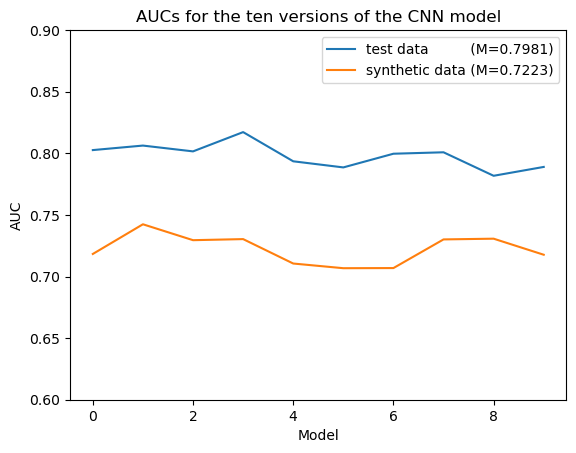

In [11]:
# plot aucs for both datasets
plt.plot(aucs_test, label=f"test data   (M={round(np.mean(aucs_test), 4)})")
plt.plot(aucs_synthetic, label=f"synthetic data (M={round(np.mean(aucs_synthetic), 4)})")
plt.ylim(.6, .9)
plt.title("AUCs for the ten versions of the CNN model")
plt.legend(loc="upper right")
plt.ylabel("AUC")
plt.xlabel("Model")
plt.show()

dataset : test   | synthetic
mean AUC: 0.7981 | 0.7223
median  : 0.8003 | 0.7239
stddev  : 0.0097 | 0.0114


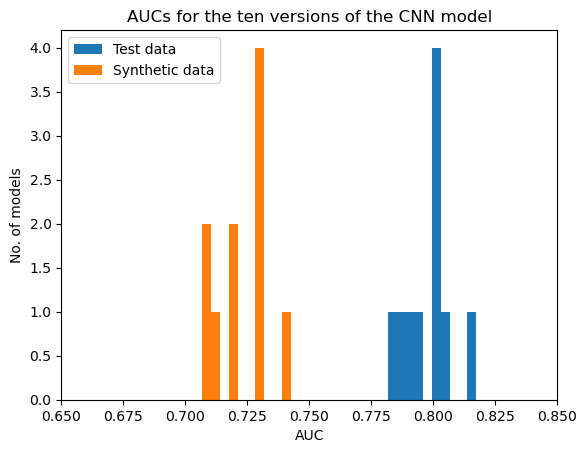

In [58]:
print('dataset : test   | synthetic')
print('mean AUC:', round(np.mean(aucs_test), 4), "|", round(np.mean(aucs_synthetic), 4))
print('median  :', round(np.median(aucs_test), 4), "|", round(np.median(aucs_synthetic), 4))
print('stddev  :', round(np.std(aucs_test), 4), "|", round(np.std(aucs_synthetic), 4))
plt.hist(aucs_test, label="Test data")
plt.hist(aucs_synthetic, label="Synthetic data")
plt.xlim([0.65, 0.85])
plt.ylabel("No. of models")
plt.xlabel("AUC")
plt.title("AUCs for the ten versions of the CNN model")
plt.legend()
plt.show()

### 2) FPED, FNED

In [12]:
def compute_confusion_counts(y_actual:np.ndarray, y_pred:np.ndarray) -> Dict[str, int]:
    """Computes confusion counts, i.e. true positive, true negative, false positive, and false negative.

    Args:
        y_actual (np.ndarray): actual labels
        y_pred (np.ndarray): predicted labels

    Returns:
        Dict[str, int]: keys = metric name, values = counts
    """
    tp = sum([a==1 and p==1 for (a, p) in zip(y_actual, y_pred)])
    tn = sum([a==0 and p==0 for (a, p) in zip(y_actual, y_pred)])
    fp = sum([a==0 and p==1 for (a, p) in zip(y_actual, y_pred)])
    fn = sum([a==1 and p==0 for (a, p) in zip(y_actual, y_pred)])
    return {"tp":tp, "tn":tn, "fp":fp, "fn":fn}

In [13]:
# TODO check these calculatiosn and synonyms

def compute_confusion_rates(y_actual:np.ndarray, y_pred:np.ndarray) -> Dict[str, int]:
    """Compute the confusion rates, i.e. true positive rate, true negative rate, false positive rate, and false negative rate.

    Args:
        y_actual (np.ndarray): actual labels
        y_pred (np.ndarray): predicted labels

    Returns:
        Dict[str, int]: keys = metric name, values = rates
    """
    conf_counts = compute_confusion_counts(y_actual, y_pred)
    actually_pos = conf_counts['tp'] + conf_counts['fn']
    actually_neg = conf_counts['tn'] + conf_counts['fp']
    
    # true positive rate = sensitivity = recall
    tpr = conf_counts['tp'] / actually_pos

    # true negative rate = specificity
    tnr = conf_counts['tn'] / actually_neg
    
    # false positive rate = fall-out
    fpr = 1 - tnr
    
    # false negative rate = miss rate
    fnr = 1 - tpr
    
    return {
        "tpr": tpr,
        "tnr": tnr,
        "fpr": fpr,
        "fnr": fnr
    }

In [14]:
# calculate per-term fprs and fnrs 

term_group = synth_data.groupby('identity_term')
per_term_fprs = dict()
overall_fprs = dict()
per_term_fnrs = dict()
overall_fnrs = dict()

for i in range(1,11): # for each model variant

    t_fprs = dict()
    t_fnrs = dict()
    for (t_name, t_df) in term_group: # for each term (t=term)
        rates = compute_confusion_rates(t_df['toxic'], t_df['pred'+str(i)])
        t_fprs[t_name] = rates['fpr']
        t_fnrs[t_name] = rates['fnr']

    per_term_fprs[str(i)] = t_fprs
    per_term_fnrs[str(i)] = t_fnrs
    
    overall_rates = compute_confusion_rates(synth_data['toxic'], synth_data['pred'+str(i)])
    overall_fprs[str(i)] = overall_rates['fpr']
    overall_fnrs[str(i)] = overall_rates['fnr']

In [15]:
# per_term_fprs

In [16]:
# overall_fprs

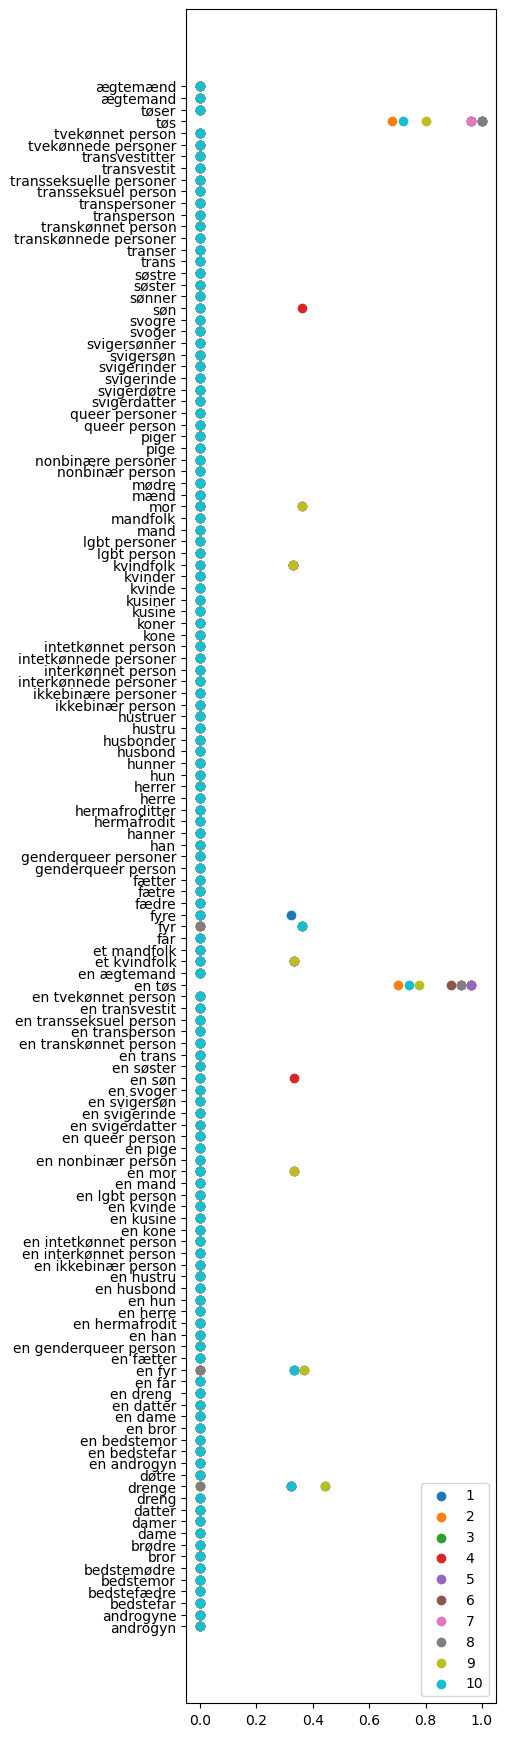

In [17]:
# plot fprs per term

plt.figure(figsize=(4,22))
for i in range(1, 11):
    y = per_term_fprs[str(i)].keys()
    x = per_term_fprs[str(i)].values()
    plt.scatter(x, y, label=i)
plt.legend()
plt.show()

In [18]:
def compute_fped(overall_fpr:float, per_term_fprs:Dict[str, float]) -> float:
    """Compute False Positive Equality Difference.

    Args:
        overall_fpr (float): false positive rate (fpr) for entire dataset
        per_term_fprs (Dict[str, float]): key = identity term, value = fpr for subset of data that contains that term

    Returns:
        float: the FPED value
    """
    fped = sum(
        abs(overall_fpr - fpr_t)
        for fpr_t in per_term_fprs.values()
    )
    return fped

In [20]:
# compute fped for each model variant
fpeds = [compute_fped(overall_fprs[str(i)], per_term_fprs[str(i)]) for i in range(1,11)]

print("Avg. FPED:", round(np.mean(fpeds),4))

Avg. FPED: 5.2235


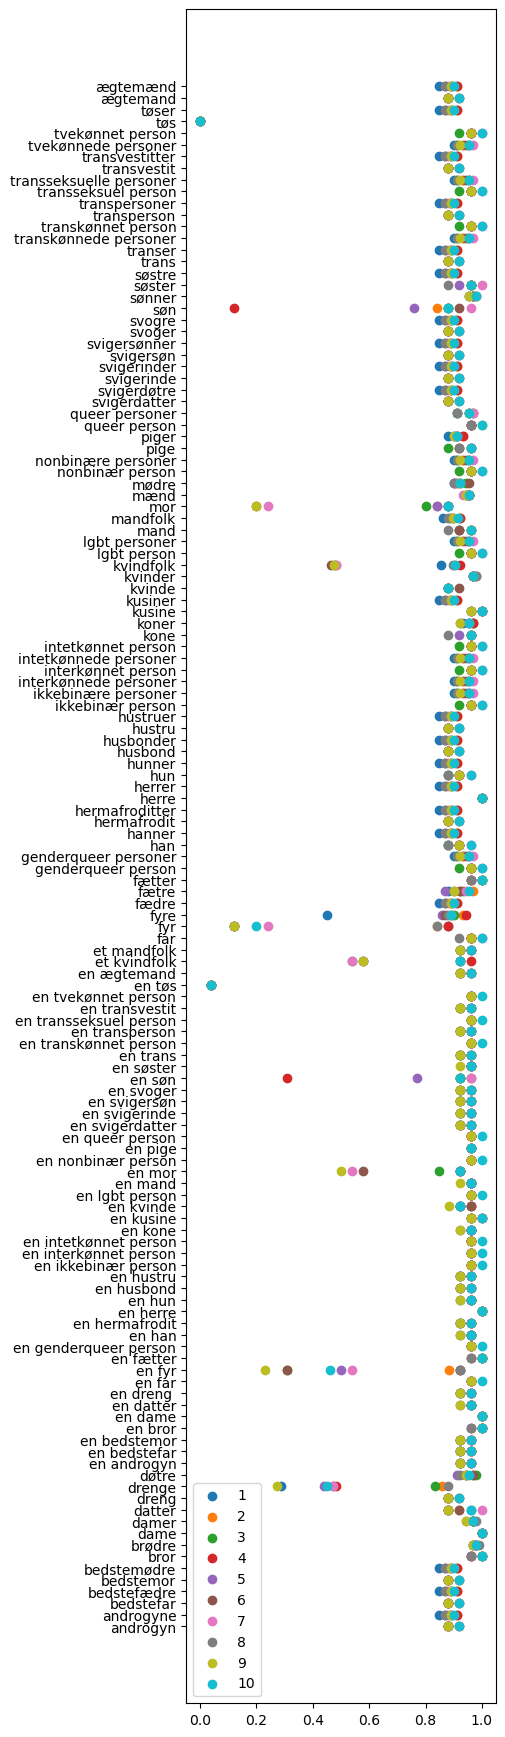

In [21]:
# plot fnrs per term

plt.figure(figsize=(4,22))
for i in range(1, 11):
    y = per_term_fnrs[str(i)].keys()
    x = per_term_fnrs[str(i)].values()
    plt.scatter(x, y, label=i)
plt.legend()
plt.show()

In [22]:
def compute_fned(overall_fnr:float, per_term_fnrs:Dict[str, float]) -> float:
    """Compute False Negative Equality Difference.

    Args:
        overall_fnr (float): false negative rate (fnr) for entire dataset
        per_term_fnrs (Dict[str, float]): key = identity term, value = fnr for subset of data that contains that term

    Returns:
        float: the FNED value
    """
    fned = sum(
        abs(overall_fnr - fnr_t)
        for fnr_t in per_term_fnrs.values()
    )
    return fned

In [23]:
# compute fned for each model variant
fneds = [compute_fned(overall_fnrs[str(i)], per_term_fnrs[str(i)]) for i in range(1,11)]

print("Avg. FNED:", round(np.mean(fneds),4))

Avg. FNED: 9.0763


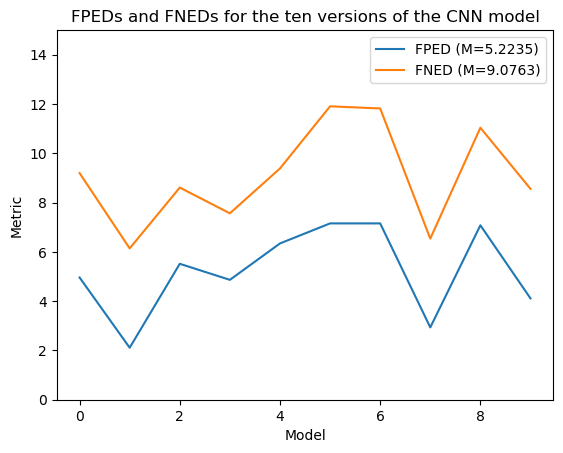

In [24]:
# plot fped and fneds
plt.plot(fpeds, label=f"FPED (M={round(np.mean(fpeds),4)})")
plt.plot(fneds, label=f"FNED (M={round(np.mean(fneds),4)})")
plt.ylim(0, 15)
plt.title("FPEDs and FNEDs for the ten versions of the CNN model")
plt.legend(loc="upper right")
plt.ylabel("Metric")
plt.xlabel("Model")
plt.show()

### 3) Subgroup AUC, BPSN AUC, and BNSP AUC

In [93]:
# for each term, calculate scores for each model variant, and take the average

per_term_scores = dict()

for (t_name, t_df) in term_group: # for each term (t=term)
    
    # subset data for calculations
    bgr_df = synth_data[synth_data['identity_term']!=t_name] # background data = data that doens't mention the current identity term
    bgr_pos = bgr_df[bgr_df['toxic']==1] # background positive
    bgr_neg = bgr_df[bgr_df['toxic']==0] # background negative
    t_pos = t_df[t_df['toxic']==1] # subgroup positive
    t_neg = t_df[t_df['toxic']==0] # subgroup negative
    bpsn_df = pd.concat([bgr_pos, t_neg])   
    bnsp_df = pd.concat([bgr_neg, t_pos])
    
    subAUCs, BPSNs, BNSPs = [], [], []
    
    for model_i in range(1, 11): # for each model variant
        
        # subAUC = AUC(sub_pos and sub_neg), i.e. entire identity subset
        subAUCs.append(roc_auc_score(t_df['toxic'], t_df['proba'+str(model_i)]))
    
        # BPSN = AUC(background positive AND subgroup negative)
        BPSNs.append(roc_auc_score(bpsn_df['toxic'], bpsn_df['proba'+str(model_i)]))
    
        # BNSP = AUC(background negative AND subgroup positive)
        BNSPs.append(roc_auc_score(bnsp_df['toxic'], bnsp_df['proba'+str(model_i)]))
    
    scores = {
        'subAUC_avg': np.mean(subAUCs),
        'BPSN_avg': np.mean(BPSNs),
        'BNSP_avg': np.mean(BNSPs),
        'subAUC_all': subAUCs,
        'BPSN_all': BPSNs,
        'BNSP_all': BPSNs
    }
    
    per_term_scores[t_name] = scores

In [26]:
# per_term_scores

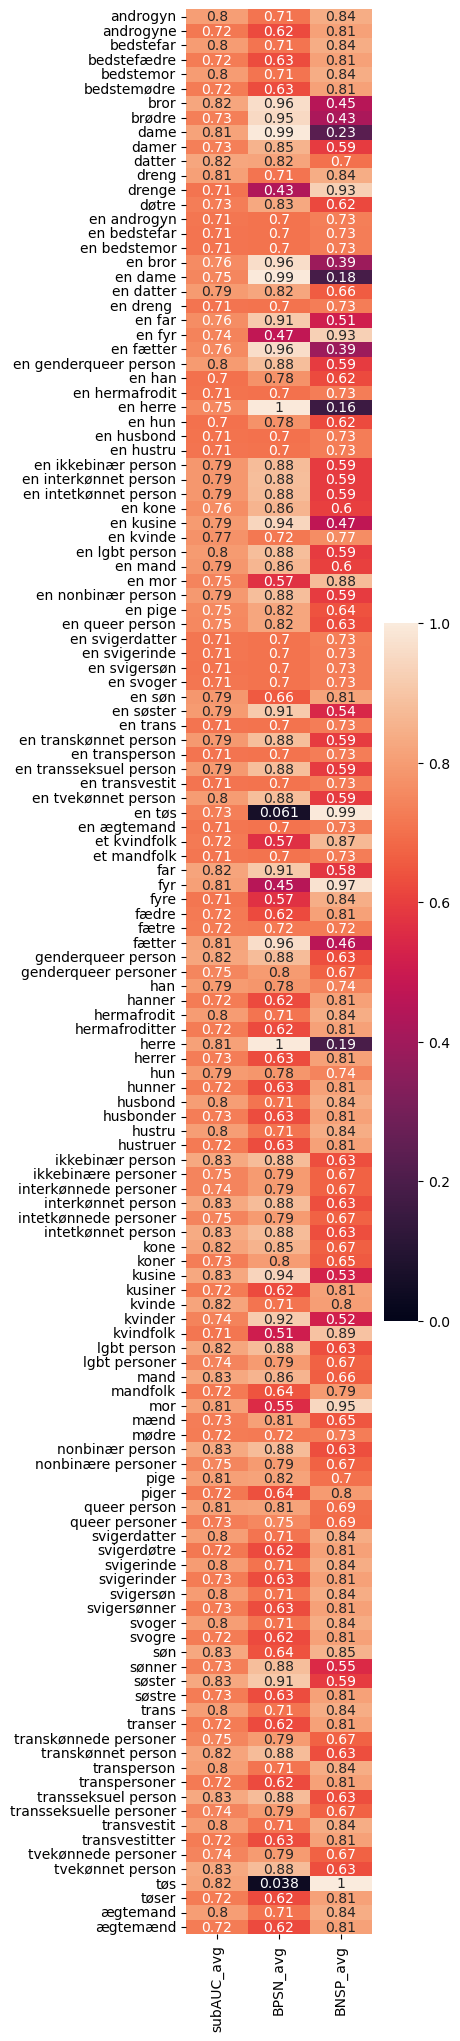

In [94]:
# df of just the averages
per_term_avgscores_df = pd.DataFrame(pd.DataFrame(per_term_scores).T.loc[:, 'subAUC_avg':'BNSP_avg'], dtype='float')
# print(per_term_avgscores_df.dtypes)

# plot average termwise auc scores
plt.figure(figsize=(3,25))
sns.heatmap(per_term_avgscores_df, annot=True, vmin=0.0, vmax=1.0)
plt.show()

#TODO maybe color words by category and plurality, e.g. female=red, male=blue, other=green, plural=deep, singular=light for readability. Maybe just some identites?

### 4) Overall metric (weighted score)

In [28]:
def power_mean(series:pd.Series, p:float) -> float:
    """Compute the power mean (generalized mean) of a series. 
    Adapted from: https://www.kaggle.com/code/dborkan/benchmark-kernel/notebook#Create-a-text-tokenizer

    Args:
        series (pd.Series): the series to compute the power mean for.
        p (float): the power value.

    Returns:
        float: the computed power mean.
    """
    total = sum(np.power(series, p))
    power_mean = np.power(total / len(series), 1 / p)
    return power_mean

def get_weighted_bias_score(bias_df:pd.DataFrame, overall_auc:float, POWER:float=-5, OVERALL_MODEL_WEIGHT:float=0.25, SUBMETRIC_WEIGHTS:List[float]=[0.25,0.25,0.25], SUBMETRIC_NAMES:List[str]=['subAUC_avg', 'BPSN_avg', 'BNSP_avg']) -> float:
    """Calculate the weighted bias score by combining the overall AUC and the generalized mean of the bias submetrics. See description at https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview/evaluation 
    Adapted from: https://www.kaggle.com/code/dborkan/benchmark-kernel/notebook#Create-a-text-tokenizer 

    Args:
        bias_df (pd.DataFrame): DataFrame containing the per-term bias submetric scores, e.g. subAUC, BPSN, and BNSP.
        overall_auc (float): ROC-AUC on the entire synthetic dataset. 
        POWER (float, optional): the power value. Defaults to -5.
        OVERALL_MODEL_WEIGHT (float, optional): the weight given to the overall model AUC. Defaults to 0.25.
        SUBMETRIC_WEIGHTS (List, optional): the weights given to each of the submetrics. Defaults to [0.25,0.25,0.25].
        SUBMETRIC_NAMES (List, optional): a list of the submetric names as they are used in the bias_df. Defaults to ['subAUC_avg', 'BPSN_avg', 'BNSP_avg'].

    Returns:
        float: the weighted bias score.
    """
    bias_score = OVERALL_MODEL_WEIGHT * overall_auc + np.sum([
        SUBMETRIC_WEIGHTS[0]*power_mean(bias_df[SUBMETRIC_NAMES[0]], POWER), # e.g. subAUC
        SUBMETRIC_WEIGHTS[1]*power_mean(bias_df[SUBMETRIC_NAMES[1]], POWER), # e.g. BPSN
        SUBMETRIC_WEIGHTS[2]*power_mean(bias_df[SUBMETRIC_NAMES[2]], POWER)  # e.g. BNSP
    ])
    return bias_score

In [29]:
print("Weighted bias score:", round(get_weighted_bias_score(per_term_avgscores_df, np.mean(aucs_synthetic)),4))

Weighted bias score: 0.4851


### 5) Positive AEG, and Negative AEG

In [ ]:
# Pseudocode

# PosAEG
# for each subgroup:
    # posAEG = 1/2 - ( MWU(subgrp_pos, bgr_pos) / subgrp_pos * bgr_pos ) # the last part is equivalent to normalized MWU

# NegAEG
# for each subgroup:
    # negAEG = 1/2 - ( MWU(subgrp_neg, bgr_neg) / subgrp_neg * bgr_neg ) # the last part is equivalent to normalized MWU

In [96]:
# these implementations are based on those at: https://github.com/conversationai/unintended-ml-bias-analysis/blob/main/archive/unintended_ml_bias/model_bias_analysis.py#L50

def normalized_mwu(data_A:pd.DataFrame, data_B:pd.DataFrame, col_name:str) -> float:
    """Calculate the normalized Mann-Whitney U test statistic for data_A and data_B.

    Args:
        data_A (pd.DataFrame): the first group of data.
        data_B (pd.DataFrame): the second group of data.
        col_name (int): the name of the column where the scores are located.

    Returns:
        float: the normalized Mann-Whitney U test statistic.
    """
    scores_A = data_A[col_name]
    scores_B = data_B[col_name]
    n_A = len(scores_A)
    n_B = len(scores_B)
    if n_A == 0 or n_B == 0:
        raise ZeroDivisionError("The length of data_A or data_B (or both) is zero.")
    
    u, p = mannwhitneyu(scores_A, scores_B, alternative='less') # u = statistic, p = p-value
    norm_mwu = u / (n_A * n_B)
    return norm_mwu

def compute_posAEG(subgroup_pos:pd.DataFrame, bgr_pos:pd.DataFrame, col_name:str) -> float:
    """Compute the positive average equality gap. 

    Args:
        subgroup_pos (pd.DataFrame): the positive examples in the subgroup data.
        bgr_pos (pd.DataFrame): the positive examples in the background data.
        col_name (str): the name of the column where the scores are located.

    Returns:
        float: the positive AEG score [-0.5, 0.5].
    """
    norm_mwu = normalized_mwu(subgroup_pos, bgr_pos, col_name) 
    pos_aeg = 0.5 - norm_mwu
    return pos_aeg
    
def compute_negAEG(subgroup_neg:pd.DataFrame, bgr_neg:pd.DataFrame, col_name:str) -> float:
    """Compute the negative average equality gap. 

    Args:
        subgroup_neg (pd.DataFrame): the negative examples in the subgroup data.
        bgr_neg (pd.DataFrame): the negative examples in the background data.
        col_name (str): the name of the column where the scores are located.

    Returns:
        float: the negative AEG score [-0.5, 0.5].
    """
    norm_mwu = normalized_mwu(subgroup_neg, bgr_neg, col_name) 
    neg_aeg = 0.5 - norm_mwu
    return neg_aeg

In [100]:
# for each term, calculate scores for each model variant, and take the average

per_term_scores = dict()

for (t_name, t_df) in tqdm(term_group): # for each term (t=term)
    
    # subset data for calculations
    bgr_df = synth_data[synth_data['identity_term']!=t_name] # background data = data that doens't mention the current identity term
    bgr_pos = bgr_df[bgr_df['toxic']==1] # background positive
    bgr_neg = bgr_df[bgr_df['toxic']==0] # background negative
    t_pos = t_df[t_df['toxic']==1] # subgroup positive
    t_neg = t_df[t_df['toxic']==0] # subgroup negative
    bpsn_df = pd.concat([bgr_pos, t_neg])   
    bnsp_df = pd.concat([bgr_neg, t_pos])
    
    subAUCs, BPSNs, BNSPs = [], [], []
    posAEGs, negAEGs = [], []
    
    for model_i in range(1, 11): # for each model variant
        
        # subAUC = AUC(sub_pos and sub_neg), i.e. entire identity subset
        subAUCs.append(roc_auc_score(t_df['toxic'], t_df['proba'+str(model_i)]))
    
        # BPSN = AUC(background positive AND subgroup negative)
        BPSNs.append(roc_auc_score(bpsn_df['toxic'], bpsn_df['proba'+str(model_i)]))
    
        # BNSP = AUC(background negative AND subgroup positive)
        BNSPs.append(roc_auc_score(bnsp_df['toxic'], bnsp_df['proba'+str(model_i)]))
        
        # AEGs
        posAEGs.append(compute_posAEG(t_pos, bgr_pos, 'proba'+str(model_i)))
        negAEGs.append(compute_negAEG(t_neg, bgr_neg, 'proba'+str(model_i)))
    
    scores = {
        'subAUC_avg': np.mean(subAUCs),
        'BPSN_avg': np.mean(BPSNs),
        'BNSP_avg': np.mean(BNSPs),
        'posAEG_avg': np.mean(posAEGs),
        'negAEG_avg': np.mean(negAEGs),
        'subAUC_all': subAUCs,
        'BPSN_all': BPSNs,
        'BNSP_all': BPSNs,
        'posAEG_all': posAEGs,
        'negAEG_all': negAEGs
    }
    
    per_term_scores[t_name] = scores

  0%|          | 0/133 [00:00<?, ?it/s]

100%|██████████| 133/133 [00:43<00:00,  3.05it/s]


In [101]:
per_term_scores

{'androgyn': {'subAUC_avg': 0.8042399999999998,
  'BPSN_avg': 0.7086290652003142,
  'BNSP_avg': 0.8381150039277298,
  'posAEG_avg': -0.16098790259230164,
  'negAEG_avg': -0.01481288295365279,
  'subAUC_all': [0.8024,
   0.8192,
   0.8168000000000001,
   0.7952,
   0.8104,
   0.8088,
   0.7856,
   0.8168,
   0.7912,
   0.796],
  'BPSN_all': [0.6991516103692066,
   0.7192301649646504,
   0.7035129615082483,
   0.7241068342498036,
   0.7099795758051847,
   0.6898318931657502,
   0.6865200314218383,
   0.7289395129615083,
   0.719362136684996,
   0.705655930871956],
  'BNSP_all': [0.6991516103692066,
   0.7192301649646504,
   0.7035129615082483,
   0.7241068342498036,
   0.7099795758051847,
   0.6898318931657502,
   0.6865200314218383,
   0.7289395129615083,
   0.719362136684996,
   0.705655930871956],
  'posAEG_all': [-0.16794344069128042,
   -0.1733040062843676,
   -0.16918774548311077,
   -0.14823566378633146,
   -0.16397486252945792,
   -0.17191201885310292,
   -0.16456873527101334,
  

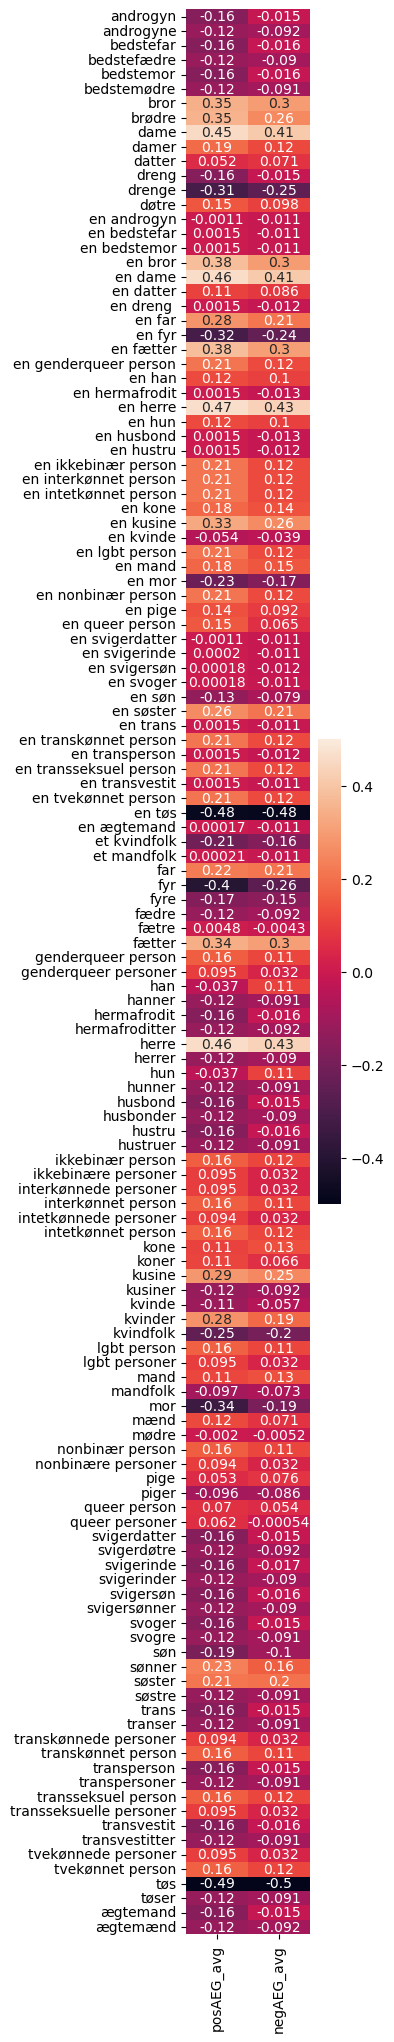

In [103]:
# df of just the averages
per_term_avgscores_df = pd.DataFrame(pd.DataFrame(per_term_scores).T.loc[:, 'posAEG_avg':'negAEG_avg'], dtype='float')
# print(per_term_avgscores_df.dtypes)

# plot average termwise auc scores
plt.figure(figsize=(2,25))
sns.heatmap(per_term_avgscores_df, annot=True, vmin=-0.5, vmax=0.5)
plt.show()

#TODO maybe color words by category and plurality, e.g. female=red, male=blue, other=green, plural=deep, singular=light for readability. Maybe just some identites?